## Deploy BLIP2 Endpoint on SageMaker

In this notebook, we will deploy a BLIP2 endpoint with DJLServing container image.

### Setup

In [1]:
import sagemaker
import jinja2
from sagemaker import image_uris
import boto3
import os
import time
import json
from pathlib import Path
import json
import base64

In [2]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

In [3]:
model_bucket = sess.default_bucket()  # bucket to house artifacts
s3_code_prefix = "blip2"  # folder within bucket where code artifact will go
s3_model_prefix = "model_blip2"  # folder within bucket where code artifact will go
region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")

jinja_env = jinja2.Environment()

# define a variable to contain the s3url of the location that has the model
pretrained_model_location = f"s3://{model_bucket}/{s3_model_prefix}/"
print(f"Pretrained model will be uploaded to ---- > {pretrained_model_location}")

Pretrained model will be uploaded to ---- > s3://sagemaker-us-east-1-822507008821/model_blip2/


## Prepare inference script and container image

In [4]:
inference_image_uri = image_uris.retrieve(
    framework="djl-deepspeed", region=sess.boto_session.region_name, version="0.22.1"
)
inference_image_uri

'763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.22.1-deepspeed0.9.2-cu118'

In [5]:
blip_model_version = "blip2-flan-t5-xl"
model_names = {
    "caption_model_name": blip_model_version, #@param ["blip-base", "blip-large", "blip2-flan-t5-xl"]
}
with open("blip2/model_name.json",'w') as file:
    json.dump(model_names, file)

In [6]:
%%sh
tar czvf model.tar.gz blip2/

blip2/
blip2/.ipynb_checkpoints/
blip2/.ipynb_checkpoints/model_name-checkpoint.json
blip2/.ipynb_checkpoints/model-checkpoint.py
blip2/.ipynb_checkpoints/requirements-checkpoint.txt
blip2/.ipynb_checkpoints/serving-checkpoint.properties
blip2/requirements.txt
blip2/serving.properties
blip2/model.py
blip2/model_name.json


In [7]:
s3_code_artifact = sess.upload_data("model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-east-1-822507008821/blip2/model.tar.gz


## Deploy model

In [8]:
from sagemaker.model import Model
from sagemaker.utils import name_from_base

model_name = name_from_base(blip_model_version)
model = Model(
    image_uri=inference_image_uri,
    model_data=s3_code_artifact,
    role=role,
    name=model_name,
)

In [9]:
endpoint_name = "endpoint-" + model_name
model.deploy(
    initial_instance_count=1,
    instance_type="ml.g5.2xlarge",
    endpoint_name=endpoint_name
)

-------------!

In [10]:
%store endpoint_name

Stored 'endpoint_name' (str)


## Test Inference Endpoint

In [11]:
from PIL import Image
import base64
import json
import boto3

smr_client = boto3.client("sagemaker-runtime")
endpoint_name = model.endpoint_name

In [12]:
def encode_image(img_file):
    with open(img_file, "rb") as image_file:
        img_str = base64.b64encode(image_file.read())
        base64_string = img_str.decode("latin1")
    return base64_string

def run_inference(endpoint_name, inputs):
    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name, Body=json.dumps(inputs)
    )
    return response["Body"].read().decode('utf-8')

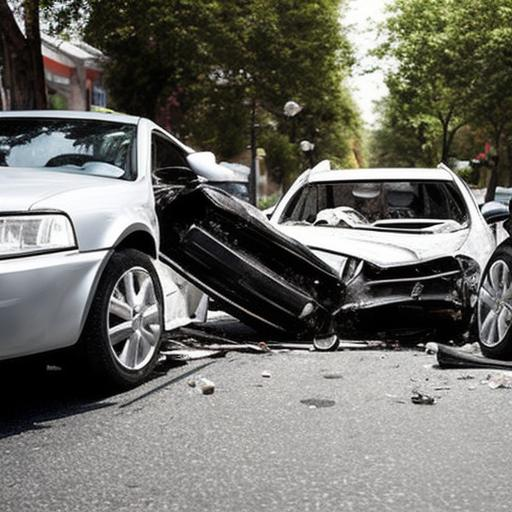

In [13]:
test_image = "carcrash-ai.jpeg"
raw_image = Image.open(test_image).convert('RGB')
display(raw_image)

### Image captioning

In [14]:
base64_string = encode_image(test_image)
inputs = {"image": base64_string}
run_inference(endpoint_name, inputs)

'a car is in a collision with another car'

### Instructed zero-shot vision-to-language generation

In [15]:
base64_string = encode_image(test_image)
inputs = {"prompt": "Question: what happened in this photo? Answer:", "image": base64_string}
run_inference(endpoint_name, inputs)

'a car accident'

In [16]:
context = [
    ("what happened in this photo?", "a car accident"),
]
question = "which parts are damaged in this car?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"
inputs = {"prompt": prompt, "image": base64_string}
run_inference(endpoint_name, inputs)

'the front end'

## Clean up

In [ ]:
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_model(ModelName=model_name)